### Importación de librerías

In [2]:
from selenium import webdriver  # Webscrapping bot
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException

from selenium.webdriver.chrome.service import Service
from selenium.webdriver.firefox.service import Service

from selenium.webdriver.firefox.options import Options as FirefoxOptions
from selenium.webdriver.chrome.options import Options as ChromiumOptions

from selenium.webdriver.common.by import By

from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC


In [3]:
from webdriver_manager.chrome import ChromeDriverManager
from webdriver_manager.firefox import GeckoDriverManager
from webdriver_manager.core.utils import ChromeType

In [4]:
import logging  # Para generar logs
from logging.handlers import TimedRotatingFileHandler
from logging import Formatter

import datetime
import os
import time

import urllib
from shutil import make_archive

In [5]:
import pandas as pd  # Manejo de dataframes

In [6]:
from IPython.display import Image
from IPython.core.display import HTML

### Variables a modificar para adaptar el código

**Principales**

In [7]:
urlToScrap = "https://images.google.com/"
numberImagesTaken = 5

pathToDF = ""
fileToDF = "https://www.dropbox.com/s/fsmrn97gbdmoznh/input_scrapping_images.csv?raw=1"
colTarget = 0

nameOutput = "output_scrapping_images.csv"
nameInter = "inter_scrapping_images.csv"

webdriverToUse = "firefox"

logPath = "webscrapping-resources/logs/"
imagesPath = "webscrapping-resources/images/"

deleteOldLogs = True
enableFullErrors = True
takeScreenshot = False
downloadImages = True
compressImages = True
linkWebCSV = True


**Firefox y Chromium**

In [8]:
privacyButton = "/html/body/div[2]/div[2]/div[3]/span/div/div/div/div[3]/div[1]/button[2]/div"
searchImageBar = "/html/body/div[1]/div[3]/form/div[1]/div[1]/div[1]/div/div[2]/input"
selectDefImage = '/html/body/div[2]/c-wiz/div[3]/div[2]/div[3]/div/div/div[3]/div[2]/c-wiz/div/div[1]/div[1]/div[3]/div/a/img'

### Pequeñas funciones de apoyo

In [9]:
# Esta función se ha creado para mejorar comprensión de código en la configuración de logs

def UTCFormatter(logFormatter):
    '''
    Recibe un formatter de logueo
    Devuelve el horario a tiempo GMT
    '''
    logFormatter.converter = time.gmtime
    return logFormatter


def pathChecker(path):
    '''
    Recibe una ruta
    Crea la ruta en local si no es encontrada
    '''
    isExist = os.path.exists(path)
    if isExist == False:
        os.makedirs(path)
        print(path + " created")


### Comprobaciones de rutas

In [10]:
pathChecker(logPath)
pathChecker(imagesPath)

### Configuración de logs

In [11]:
# Se inicia el proceso de registro de logs a nivel de INFO.
logger = logging.getLogger('ScrapLog')
logger.setLevel(logging.INFO)

# Variables que determinan apartados posteriores
timestamp = datetime.datetime.utcnow().strftime('%Y%m%d_%H-%M-%S')
filename = f'ScrapImages{timestamp}.log'
formatter = logging.Formatter(
    '[%(asctime)s] %(name)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s')


In [12]:
'''
Indican como se debe crear el archivo de log
Si "deleteOldLogs" es True, sólo se conservará el último archivo de log
'''
if deleteOldLogs == True:
    listFilesinCWD = os.listdir(logPath)
    workPath = os.getcwd()
    os.chdir(logPath)
    for element in listFilesinCWD:
        if element.endswith(".log"):
            os.remove(os.path.join(os.getcwd(), element))
        if element.endswith(".png"):
            os.remove(os.path.join(os.getcwd(), element))
    os.chdir(workPath)


In [13]:
fileHandler = logging.FileHandler(filename=f"{logPath}{filename}")
logging.Formatter.converter = time.gmtime

fileHandler.setLevel(logging.INFO)
fileHandler.setFormatter(UTCFormatter(formatter))
logger.addHandler(fileHandler)

### Importación de datos

Se importa el dataset especificado en las variables generales definidas anteriormente.

In [14]:
if linkWebCSV:
    df = pd.read_csv(fileToDF)
else:
    df = pd.read_csv(f"{pathToDF}{fileToDF}")
    # df.drop(columns=df.columns[0], axis=1, inplace=True)

Comprobación de tamaño y composición del dataset importado como dataframe de Pandas.

In [17]:
print(df.shape)
df.head()

(2779, 1)


,0
1800,Perejil ultracongelado Carrefour 50 g.
1801,Albahaca en hoja Carrefour 15 g.
1802,Ajo y perejíl Especias tarrina 30 g
1803,Molinillo pimienta negra en grano Carrefour 45 g.
1804,Ajo en polvo Carmencita 60 g.


### Lógica del Scrapping

La siguiente función otorga soporte para scrapear varias imágenes por producto.

In [15]:
def SelectImageSearched(numberImage):
    imageSearched = f"/html/body/div[2]/c-wiz/div[3]/div[1]/div/div/div/div[1]/div[1]/span/div[1]/div[1]/div[{numberImage}]/a[1]/div[1]/img"
    return imageSearched

La siguiente función obtiene la url del primer resultado que aparece en google imágenes con el nombre del producto que recibe.

In [16]:
def ScrapFunction(position, prodToScrap, urlToScrap, driver, numberImage):
    try:

        logger.info(f"Started with: {prodToScrap} and {numberImage} iteration")
                
        driver.get(urlToScrap)
        
        if position == 0 and numberImage==1:
            driver.find_element(By.XPATH, privacyButton).click()

        selectImageBox=driver.find_element(By.XPATH, searchImageBar)
        selectImageBox.send_keys(prodToScrap)
        selectImageBox.send_keys(Keys.ENTER)

        time.sleep(1)
        driver.find_element(By.XPATH, SelectImageSearched(numberImage)).click()
        time.sleep(1)
        
        urlImage = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, selectDefImage))).get_attribute("src")

        logger.info(f"Scrapped: {urlImage}")

        if takeScreenshot:
            driver.save_screenshot(f"{logPath}Selenium-Progress.png")

        if downloadImages:
            pathChecker(imagesPath + prodToScrap)
            urllib.request.urlretrieve(urlImage, f"{imagesPath}{prodToScrap}/{prodToScrap}-{numberImage}.png")
            
        return urlImage

    except:
        if enableFullErrors:
            logger.exception('')
            if position == 0:
                driver.save_screenshot(f"{logPath}Selenium-CrashBrowser.png")  
        else:
            logger.info(f"FUNCTIONERROR: {prodToScrap}")
        return None

**Ejecución de Selenium**. Tiene configurado tanto webdriver de *Chromium* como de *Firefox* por cuestiones de *debugging* (especialmente en términos de rendimiento). Finalmente se empleó geckodriver con *Firefox* (definido en variables generales anteriormente) en una instancia 'C2-standard-4' de *Google Cloud* con una duración total de 28 horas de cálculo.

El siguiente código traslada los nombres de los productos de uno en uno a la función anterior de Scrapeo y, con la url obtenida, lo graba en la columna generada "url" en el índice apropiado.

In [17]:
print("Starting Webscrapping!")

if webdriverToUse != "firefox":
    ser = Service(executable_path=ChromeDriverManager(chrome_type=ChromeType.CHROMIUM).install(), log_path=f"{logPath}selenium.log")
    opts = ChromiumOptions()
    opts.headless = True
    opts.add_argument("--no-sandbox")
    opts.add_argument("--incognito")
    opts.add_argument("--headless")
    opts.add_argument("--window-size=1920,1080")

    driver = webdriver.Chrome(service=ser, options=opts)

else:
    ser = Service(executable_path=GeckoDriverManager().install(), log_path=f"{logPath}geckodriver.log")
    opts = FirefoxOptions()
    opts.add_argument("--no-sandbox")
    opts.add_argument("start-maximized")
    opts.add_argument("--headless")
    
    driver = webdriver.Firefox(service=ser, options=opts)

driver.implicitly_wait(10)
driver.set_page_load_timeout(30)
driver.set_window_size(1920, 1080)


for position, element in enumerate(df[f"{colTarget}"].tolist()):
    for element2 in range(1,numberImagesTaken):
        urlScrapped = ScrapFunction(position, element, urlToScrap, driver, element2)
        df.loc[df.index[position], f'url{element2}'] = urlScrapped
        if position % 10:
            df.to_csv(nameInter)
    if position % 10:
        df.to_csv(nameInter)

if compressImages:
    make_archive('compressed_output_scrapping_images', 'zip', root_dir=imagesPath)

Starting Webscrapping!

webscrapping-resources/images/Picada de vacuno ecológico Carrefour Bio 400 g created
webscrapping-resources/images/Hamburguesa de vacuno ecológica sin gluten y sin lactosa Carrefour Bio 2x120 g created
webscrapping-resources/images/Carpaccio de vacuno ecológico Carrefour Bio 120 g aprox created


In [16]:
# Chequeo preliminar de resultados obtenidos
df.head()

,0,url1,url2,url3,url4
0,Picada de vacuno ecológico Carrefour Bio 400 g,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",https://static.carrefour.es/hd_510x_/img_pim_f...,https://a2.soysuper.com/696e522b4ad34a20e9d73f...,https://thefoodplease.com/wp-content/uploads/2...
1,Hamburguesa de vacuno ecológica sin gluten y s...,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",https://static.carrefour.es/hd_510x_/img_pim_f...,https://static.carrefour.es/hd_510x_/img_pim_f...,https://dmerka.com/wp-content/uploads/2021/01/...
2,Carpaccio de vacuno ecológico Carrefour Bio 12...,https://static.carrefour.es/hd_510x_/img_pim_f...,https://static.carrefour.es/hd_510x_/img_pim_f...,https://dmerka.com/wp-content/uploads/2021/01/...,https://d2ohdpvxj0yo9f.cloudfront.net/products...
3,Filete 1ªA de añojo ecológico Carrefour Bio 50...,https://static.carrefour.es/hd_510x_/img_pim_f...,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",https://static.carrefour.es/hd_350x_/img_pim_f...,https://d2ohdpvxj0yo9f.cloudfront.net/products...
4,Entrecot de añojo ecológico Carrefour Bio 500 ...,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",https://dmerka.com/wp-content/uploads/2021/01/...,https://static.carrefour.es/hd_510x_/img_pim_f...,https://static.carrefour.es/hd_510x_/img_pim_f...



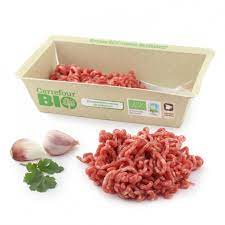

In [18]:
Image(url=df["url1"][0])

### Exportación de resultados a formato CSV

In [ ]:
# Importante no eliminar "index=False" para mantener homogeneidad de los datos.
df.to_csv(nameOutput, index=False)